In [1]:
import os
import random
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import nibabel as nb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tqdm.notebook import tqdm
from skimage.measure import label
from numpy.polynomial.polynomial import polyfit


from dpipe.io import load, save
from dpipe.im.visualize import slice3d
from dpipe.im.metrics import fraction

from ufroc.utils import np_sigmoid
from ufroc.paths import EXP_BASE_PATH

In [2]:
plt.rcParams.update({'font.size': 22, 'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',})


In [3]:
methods = ['logit_1', 'logit_n',
           'pred_1', 'pred_n',
           'avg_entropy', 'dispersion', 'mutual_info',
           'obj_dsc',]

aggregations = ['mean', 'median', 
                'min', 'q5',
                'max', 'q95',
                'sum_log']

proba_ths = np.array([0.25, 0.5, 0.75, ])

In [4]:
def concat_two_dfs_probably_with_none(df0, df1):
    if df0 is None:
        return df1
    else:
        return pd.concat((df0, df1)).reset_index(drop=True)


def load_dfs(exps, from_single=False):
    base_path = Path(EXP_BASE_PATH)
    df_true, df_pred, df_hit = None, None, None
    for exp in exps:
        froc_path = base_path / f'{exp}_froc'
        if from_single:
            froc_path = base_path / f'{exp}_froc_single'
        js_ids = os.listdir(froc_path)
        js_ids = np.unique(['_'.join(fname.split('_')[:-1]) for fname in js_ids])


        for js_id in js_ids:
            records_true = load(froc_path / f'{js_id}_true.json')
            records_pred = load(froc_path / f'{js_id}_pred.json')
            records_hit = load(froc_path / f'{js_id}_hit.json')

            df_true = concat_two_dfs_probably_with_none(df_true, pd.DataFrame.from_records(records_true))
            df_pred = concat_two_dfs_probably_with_none(df_pred, pd.DataFrame.from_records(records_pred))
            df_hit = concat_two_dfs_probably_with_none(df_hit, pd.DataFrame.from_records(records_hit))
    
    if len(df_true) > 0:
        # generation instance ids:
        true_instance_id = np.array([f'{obj_id}|{_id}' for obj_id, _id
                                     in zip(df_true['obj_id'].values, df_true['ID'].values)])
        df_true['true_instance_id'] = true_instance_id
    if len(df_pred) > 0:
        pred_instance_id = np.array([f'{obj_id}|{_id}' for obj_id, _id
                                     in zip(df_pred['obj_id'].values, df_pred['ID'].values)])
        df_pred['pred_instance_id'] = pred_instance_id
    if len(df_hit) > 0:
        true_instance_id = np.array([f'{obj_id}|{_id}' for obj_id, _id
                                     in zip(df_hit['hit_id'].values, df_hit['ID'].values)])
        pred_instance_id = np.array([f'{obj_id}|{_id}' for obj_id, _id
                                     in zip(df_hit['obj_id'].values, df_hit['ID'].values)])
        df_hit['true_instance_id'] = true_instance_id
        df_hit['pred_instance_id'] = pred_instance_id
    
    
    return df_true, df_pred, df_hit

def load_dfs_with_dsc(df1, df2, from_single=False):
    df_true, df_pred, df_hit = load_dfs([df1], from_single=from_single)
    df_pred["DSC"] = [df_hit[(df_hit.pred_instance_id == row.pred_instance_id) &
                             (df_hit.proba_th == row.proba_th)].DSC.max()
                                                    for _, row in df_pred.iterrows()]
    df_pred.DSC = df_pred.DSC.fillna(0)
    df_pred["source"] = (df_pred["DSC"] == 0).astype(np.int32)
    lungs = df_pred
    df_true, df_pred, df_hit = load_dfs([df2])
    df_pred["source"] = 2
    df_pred["DSC"] = 0
    return concat_two_dfs_probably_with_none(lungs, df_pred)

def get_metrics(df_true, df_pred, df_hit, proba_th, stat_name, compare_fn,
                hit_def_dice_th=0, num_points=100):
    df_pred = df_pred[df_pred['proba_th'] == proba_th]
    df_hit = df_hit[df_hit['proba_th'] == proba_th]
    
    df_hit = df_hit[df_hit['DSC'] > hit_def_dice_th]
    
    # memory-time savings
    df_pred = pd.concat((df_pred['pred_instance_id'], df_pred[stat_name]), axis=1)
    
    stat_min, stat_max, th_eps = df_pred[stat_name].min(), df_pred[stat_name].max(), 1
    stat_values = sorted(df_pred[stat_name])
    stat_values = [stat_values[0] - th_eps] + stat_values
    l = len(stat_values) // num_points
    stat_thresholds = stat_values[::l] + [stat_values[-1] + th_eps]
    
    metrics = defaultdict(list)
    true_ids_all = df_true['true_instance_id'].values
    n_true, n_images = len(true_ids_all), len(df_true['ID'].unique())
    df_pred_sorted = df_pred.sort_values(by=stat_name, ascending=False)
    for th in tqdm(stat_thresholds):
        df_pred_th = df_pred[compare_fn(df_pred[stat_name], th)]
        
        pred_ids_all = df_pred_th['pred_instance_id'].values
        pred_ids_hit_flt_ind = df_hit['pred_instance_id'].apply(lambda x: x in pred_ids_all)
        
        df_hit_th = df_hit[pred_ids_hit_flt_ind]
        pred_ids_hit = df_hit_th['pred_instance_id'].unique()
        true_ids_hit = df_hit_th['true_instance_id'].unique()
        
        fp = len(pred_ids_all) - len(pred_ids_hit)
        n_true_hit = len(true_ids_hit)
        tp = n_true_hit
        fn = n_true - n_true_hit
        
        metrics['fp'].append(fp)
        metrics['tp'].append(tp)
        metrics['fn'].append(fn)
        
        metrics['recall'].append(fraction(tp, n_true))
        metrics['precision'].append(fraction(tp, tp + fp))
        metrics['avg_fp'].append(fp / n_images)
        
        obj_dscs = df_hit_th.groupby('true_instance_id').max('DSC')['DSC'].values
        metrics['obj_dsc_TP'].append(0 if len(obj_dscs) == 0 else np.mean(obj_dscs))
        metrics['obj_dsc'].append(0 if len(obj_dscs) == 0 else metrics['obj_dsc_TP'][-1] * len(obj_dscs) / len(pred_ids_hit) )        
        metrics['obj_dsc_std'].append(0 if len(obj_dscs) == 0 else np.std(obj_dscs))
        metrics['coverage'].append(fraction(len(df_pred_th), len(df_pred)))
        metrics["th"].append(th)
    
    return metrics


def ge(a, b):
    return a > b


def le(a, b):
    return a < b


def froc2avg_recall(avg_fp, recall, compare_fn, max_fp=5):
    axis0, axis1 = avg_fp[:], recall[:]
    if compare_fn(1, 2):
        axis0, axis1 = axis0[::-1], axis1[::-1]
    
    axis0.append(0)
    axis1.append(0)
    
    x_points = np.linspace(0, max_fp, max_fp*100+1)
    avg_recall = np.mean(np.interp(x_points, axis0[::-1], axis1[::-1]))
        
    return avg_recall
    
    
def plot_curves(exps, setups, x="avg_fp", y="recall", num_points=100, print_metric=True, from_single=False, have_labels=True):
    if type(exps) is not list:
        exps = [exps]
    df_true, df_pred, df_hit = load_dfs(exps, from_single)
    exp = exps[0]
#     plt.figure(figsize=(15, 8), dpi=150)
    exp_names = [{"lidc": "LIDC", 
                 "midrc": "MIDRC",
                 "met": "Mets", 
                 "lits_mod": "LiTS-mod",
                 "lits": "LiTS", 
                 "egd": "EGD",
                }[e] for e in exps]
    plt.title("+".join(exp_names), fontsize=24, fontweight='bold')
    stats = {}
    for i, (method, aggr, compare_fn, proba_th) in enumerate(setups):
        stat_name = f'{method}|{aggr}'
        metrics = get_metrics(df_true, df_pred, df_hit, proba_th, stat_name, compare_fn, num_points=num_points)
        linestyle = '--' if 'max' in stat_name else '-'
        label_name = None
        if have_labels:
            label_name = {'pred_n|max': 'Ens. pred (max)',
                         'entropy_n|mean': 'Ens. entropy',
                         'obj_dsc|mean': 'Ens. obj_dsc',
                         'pred_1|max': 'pred (max)',
                         'entropy_1|mean': 'entropy',}.get(stat_name, stat_name)
        plt.plot(metrics[x], metrics[y], label=label_name,
                 linewidth=1.8, linestyle=linestyle, c=plt.cm.tab10(i + 2 if not from_single else i))
        
        if print_metric:
            recall_95_level = np.argmin(np.abs(np.array(metrics[y]) - 0.95*max(metrics[y])))
            false_positives = metrics[x][recall_95_level]
            avg_recall = froc2avg_recall(metrics[x], metrics[y], compare_fn)
            print(f'{stat_name:20s} (avg recall) = {avg_recall:.3f}, (fp@95recall) = {false_positives:.3f}')
            stats[stat_name] = {"avg_recall": avg_recall,
                               "fp@95recall": false_positives,
                               "fpr@95reduction": 1 - false_positives/max(metrics[x])}
        
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.xscale("log")
    plt.xlabel("FPs per Image")
    plt.ylabel("Recall")
#     plt.show()
    return stats






In [5]:
lungs = load_dfs_with_dsc("lidc", "midrc")
liver = load_dfs_with_dsc("lits", "lits_mod")
brain = load_dfs_with_dsc("met", "egd")



<AxesSubplot:xlabel='avg_entropy|mean', ylabel='Count'>

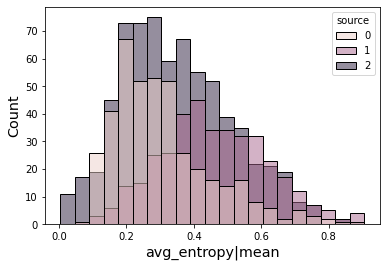

In [6]:
sns.histplot(data=lungs[lungs.proba_th == 0.5], x="avg_entropy|mean", hue="source")

## Explore Correlations

In [7]:
all_correlation = []
for df in [liver, lungs, brain]:
    for i in range(2):
        sub_df = df[df.proba_th == 0.5]
        if i == 0:
            sub_df = sub_df[sub_df.source == 0]
        else:
            sub_df = sub_df[sub_df.source != 2]
            
        correlations = {}
        for x in sub_df.columns[3:-3]:
            try:
                correlations[x] = abs(stats.pearsonr(sub_df[x].values, sub_df.DSC.values)[0])
            except:
                print(x)
        all_correlation.append(correlations)


logit_1|sum_log
mutual_info|sum_log
logit_1|sum_log
mutual_info|sum_log
logit_1|sum_log
mutual_info|sum_log
logit_1|sum_log
mutual_info|sum_log
logit_1|sum_log
mutual_info|sum_log
logit_1|sum_log
mutual_info|sum_log


In [8]:
corr_frame = pd.DataFrame(all_correlation, index=["liver", "liver+FP", "lungs", "lungs+FP", "brain", "brain+FP"])
corr_frame

,logit_1|mean,logit_1|median,logit_1|min,logit_1|q5,logit_1|max,logit_1|q95,logit_n|mean,logit_n|median,logit_n|min,logit_n|q5,...,mutual_info|q5,mutual_info|max,mutual_info|q95,obj_dsc|mean,obj_dsc|median,obj_dsc|min,obj_dsc|q5,obj_dsc|max,obj_dsc|q95,obj_dsc|sum_log
liver,0.538106,0.499162,0.468842,0.227127,0.687779,0.658788,0.752994,0.744153,0.307163,0.729938,...,0.502427,0.177627,0.543126,0.729311,0.709166,0.661106,0.676869,0.675107,0.683148,0.608572
liver+FP,0.591145,0.562297,0.012308,0.214742,0.774183,0.744549,0.875518,0.872224,0.163000,0.858644,...,0.447384,0.204413,0.489394,0.731520,0.696944,0.814022,0.813364,0.561421,0.584149,0.507565
lungs,0.534470,0.534073,0.078606,0.149136,0.572548,0.574435,0.651976,0.645827,0.036236,0.538822,...,0.650325,0.301254,0.587380,0.793982,0.804754,0.647753,0.680711,0.757159,0.772512,0.721137
lungs+FP,0.501604,0.490571,0.193382,0.021644,0.605485,0.598368,0.682796,0.670000,0.049769,0.517797,...,0.397323,0.171858,0.444528,0.577873,0.535472,0.582304,0.591316,0.441840,0.463379,0.477234
brain,0.580687,0.578876,0.023422,0.290145,0.519317,0.557305,0.615518,0.603853,0.106586,0.493427,...,0.377984,0.256551,0.556064,0.733595,0.714997,0.699327,0.711743,0.609318,0.634513,0.582227
brain+FP,0.485004,0.475697,0.109518,0.103582,0.530345,0.531300,0.587957,0.578835,0.050177,0.494985,...,0.333027,0.285083,0.443355,0.510359,0.475761,0.550043,0.549314,0.394171,0.410273,0.415328


In [9]:
corr_frame = corr_frame.T.sort_values("liver", ascending=False)
corr_frame

,liver,liver+FP,lungs,lungs+FP,brain,brain+FP
entropy_n|mean,0.822787,0.867110,0.751168,0.645717,0.696360,0.583480
pred_n|mean,0.820736,0.784289,0.777272,0.602232,0.720528,0.553140
pred_n|median,0.819635,0.817467,0.757864,0.585048,0.702832,0.546854
entropy_n|median,0.796989,0.896434,0.728660,0.644211,0.672264,0.582332
entropy_n|q5,0.762241,0.738043,0.730694,0.545705,0.648039,0.508424
...,...,...,...,...,...,...
logit_n|sum_log,0.086609,0.185144,0.247293,0.263665,0.150332,0.232778
dispersion|max,0.083413,0.127305,0.126028,0.039517,0.003966,0.118903
entropy_n|sum_log,0.076040,0.196241,0.261696,0.292441,0.144379,0.235304
avg_entropy|sum_log,0.069001,0.192555,0.258283,0.297941,0.144856,0.235228


In [10]:
corr_frame_ch = corr_frame.loc[['pred_n|max','avg_entropy|mean', 'logit_n|mean', 'pred_n|mean', 
                                'entropy_n|mean','mutual_info|mean', 
                                'obj_dsc|mean',
                                 'dispersion|min']]
# corr_frame_ch = corr_frame.loc[['pred_1|max', 'logit_1|mean', 'pred_1|mean','entropy_1|mean']]

corr_frame_ch

,liver,liver+FP,lungs,lungs+FP,brain,brain+FP
pred_n|max,0.658764,0.572592,0.712002,0.474574,0.625806,0.439281
avg_entropy|mean,0.722494,0.614570,0.441321,0.520229,0.609498,0.482073
logit_n|mean,0.752994,0.875518,0.651976,0.682796,0.615518,0.587957
pred_n|mean,0.820736,0.784289,0.777272,0.602232,0.720528,0.553140
entropy_n|mean,0.822787,0.867110,0.751168,0.645717,0.696360,0.583480
mutual_info|mean,0.631758,0.547113,0.746610,0.488059,0.588148,0.428473
obj_dsc|mean,0.729311,0.731520,0.793982,0.577873,0.733595,0.510359
dispersion|min,0.481732,0.294858,0.653570,0.343204,0.442667,0.286537


In [11]:
print(corr_frame_ch.to_latex(float_format="%.2f"))


\begin{tabular}{lrrrrrr}
\toprule
{} &  liver &  liver+FP &  lungs &  lungs+FP &  brain &  brain+FP \\
\midrule
pred\_n|max       &   0.66 &      0.57 &   0.71 &      0.47 &   0.63 &      0.44 \\
avg\_entropy|mean &   0.72 &      0.61 &   0.44 &      0.52 &   0.61 &      0.48 \\
logit\_n|mean     &   0.75 &      0.88 &   0.65 &      0.68 &   0.62 &      0.59 \\
pred\_n|mean      &   0.82 &      0.78 &   0.78 &      0.60 &   0.72 &      0.55 \\
entropy\_n|mean   &   0.82 &      0.87 &   0.75 &      0.65 &   0.70 &      0.58 \\
mutual\_info|mean &   0.63 &      0.55 &   0.75 &      0.49 &   0.59 &      0.43 \\
obj\_dsc|mean     &   0.73 &      0.73 &   0.79 &      0.58 &   0.73 &      0.51 \\
dispersion|min   &   0.48 &      0.29 &   0.65 &      0.34 &   0.44 &      0.29 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_4078186/110080717.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(corr_frame_ch.to_latex(float_format="%.2f"))


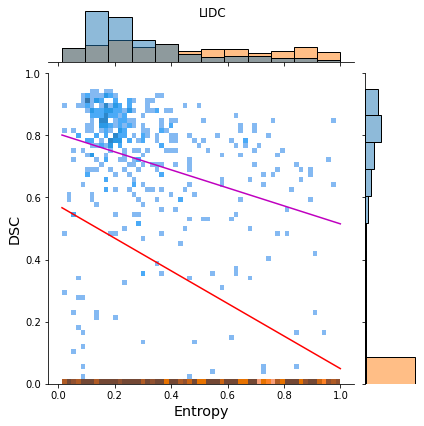

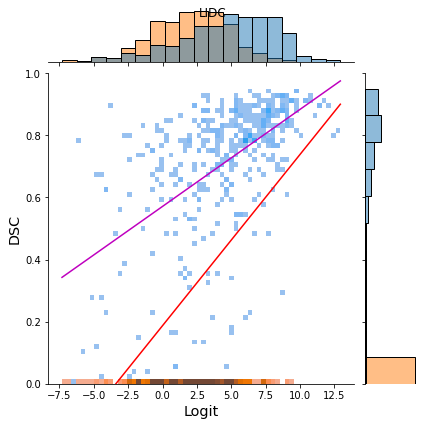

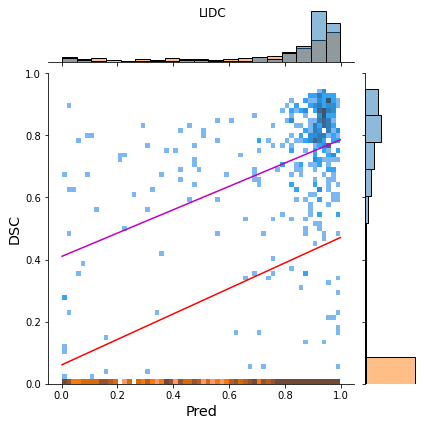

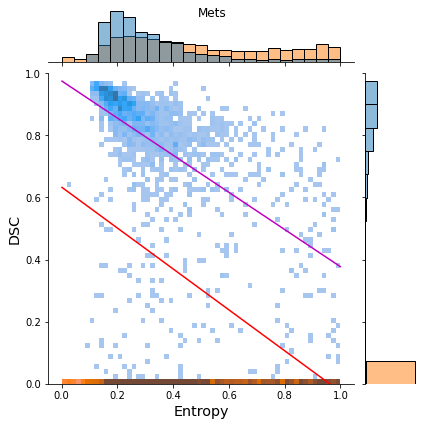

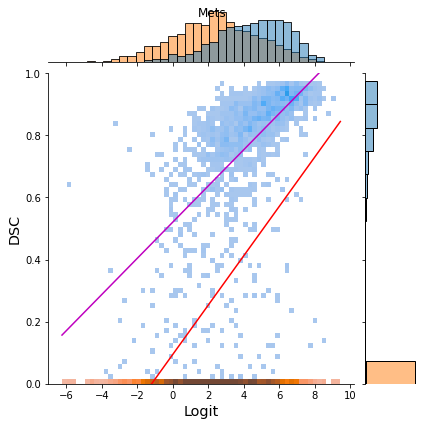

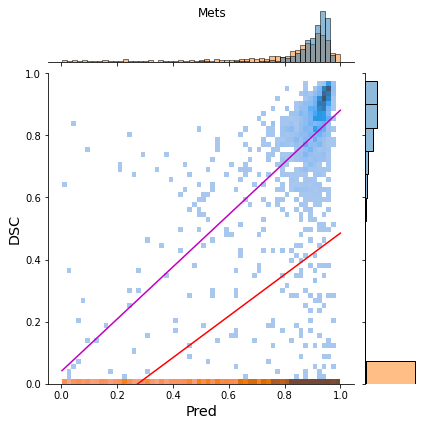

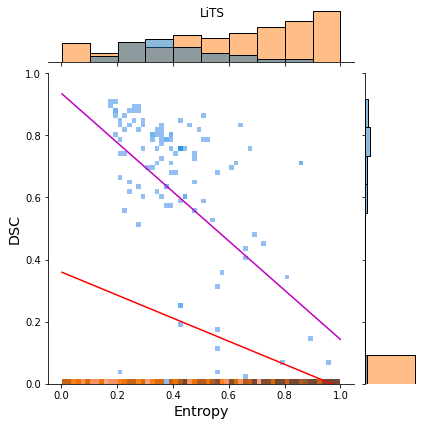

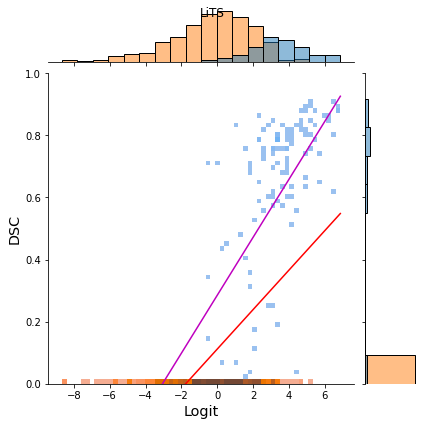

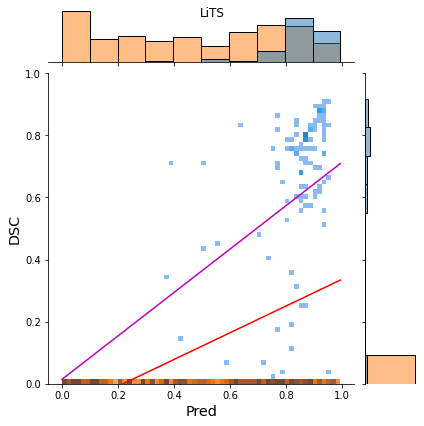

In [12]:
for name, df in {"LIDC": lungs,
                "Mets": brain,
                "LiTS": liver}.items():
    sub_df = df[(df.proba_th == 0.5) & (df.source != 2)]
    sub_df1 = sub_df[sub_df.source == 0]

    for i in range(3):
#         stat_name = ['entropy_n|mean', 'logit_n|mean', 'obj_dsc|mean'][i]
#         new_stat_name = ['Ensemble, Entropy', 'Ensemble, Logit', 'Ensemble, Obj_dsc'][i]
        stat_name = ['entropy_1|mean', 'logit_1|mean', 'pred_1|mean'][i]
        new_stat_name = ['Entropy', 'Logit', 'Pred'][i]

        ax1= sns.jointplot( data=sub_df, x=stat_name, y="DSC", kind="hist", bins=60, pmax=.7, hue="source")
        x = np.linspace(sub_df[stat_name].min(), sub_df[stat_name].max(), 100)
        b, m = polyfit(sub_df[stat_name], sub_df.DSC, 1)
        b1, m1 = polyfit(sub_df1[stat_name], sub_df1.DSC, 1)
#         plt.legend(["False Positive ", "True Positive"])

        ax1.ax_joint.plot(x, b + m* x, c="r",)
        ax1.ax_joint.plot(x, b1 + m1* x, c="m",)
        ax1.ax_joint.legend([],[], frameon=False)
        ax1.ax_joint.set_ylim(0,1)

#         ax1.ax_joint.legend(["Correlation of TP+FP", "Correlation of TP"])
        ax1.fig.suptitle(name)
        ax1.ax_joint.set_xlabel(new_stat_name)
        plt.savefig(f"../imgs/{name}_{stat_name}.png")


# FROCs

In [13]:
exp = 'met'
methods = [
           'logit_n', 'pred_n','obj_dsc',
           'avg_entropy', 'dispersion', 'mutual_info',
           ]

aggregations = ['mean', 'median', 
                'min', 'q5',
                'max', 'q95',
                'sum_log']

setups =  [(method, agg, ge, 0.5) for method in ['logit_n', 'pred_n','obj_dsc'] for agg in aggregations] + \
          [(method, agg, le, 0.5) for method in ['entropy_n', 'avg_entropy', 'dispersion', 'mutual_info'] for agg in aggregations]
setups = setups[:-1] #MI and sum_log don't work together

# setups =  [(method, agg, ge, 0.5) for method in ['logit_1', 'pred_1'] for agg in aggregations] + \
#           [(method, agg, le, 0.5) for method in ['entropy_1'] for agg in aggregations]

setups = [('pred_n', 'max', ge, 0.5),
         ('entropy_n', 'mean', le, 0.5),
         ('obj_dsc', 'mean', ge, 0.5)]


# met_stats = plot_curves(exp, setups, x="avg_fp", y="recall", num_points=100)

  0%|          | 0/102 [00:00<?, ?it/s]

pred_n|max           (avg recall) = 0.687, (fp@95recall) = 3.221


  0%|          | 0/102 [00:00<?, ?it/s]

entropy_n|mean       (avg recall) = 0.687, (fp@95recall) = 3.129


  0%|          | 0/102 [00:00<?, ?it/s]

obj_dsc|mean         (avg recall) = 0.680, (fp@95recall) = 2.858


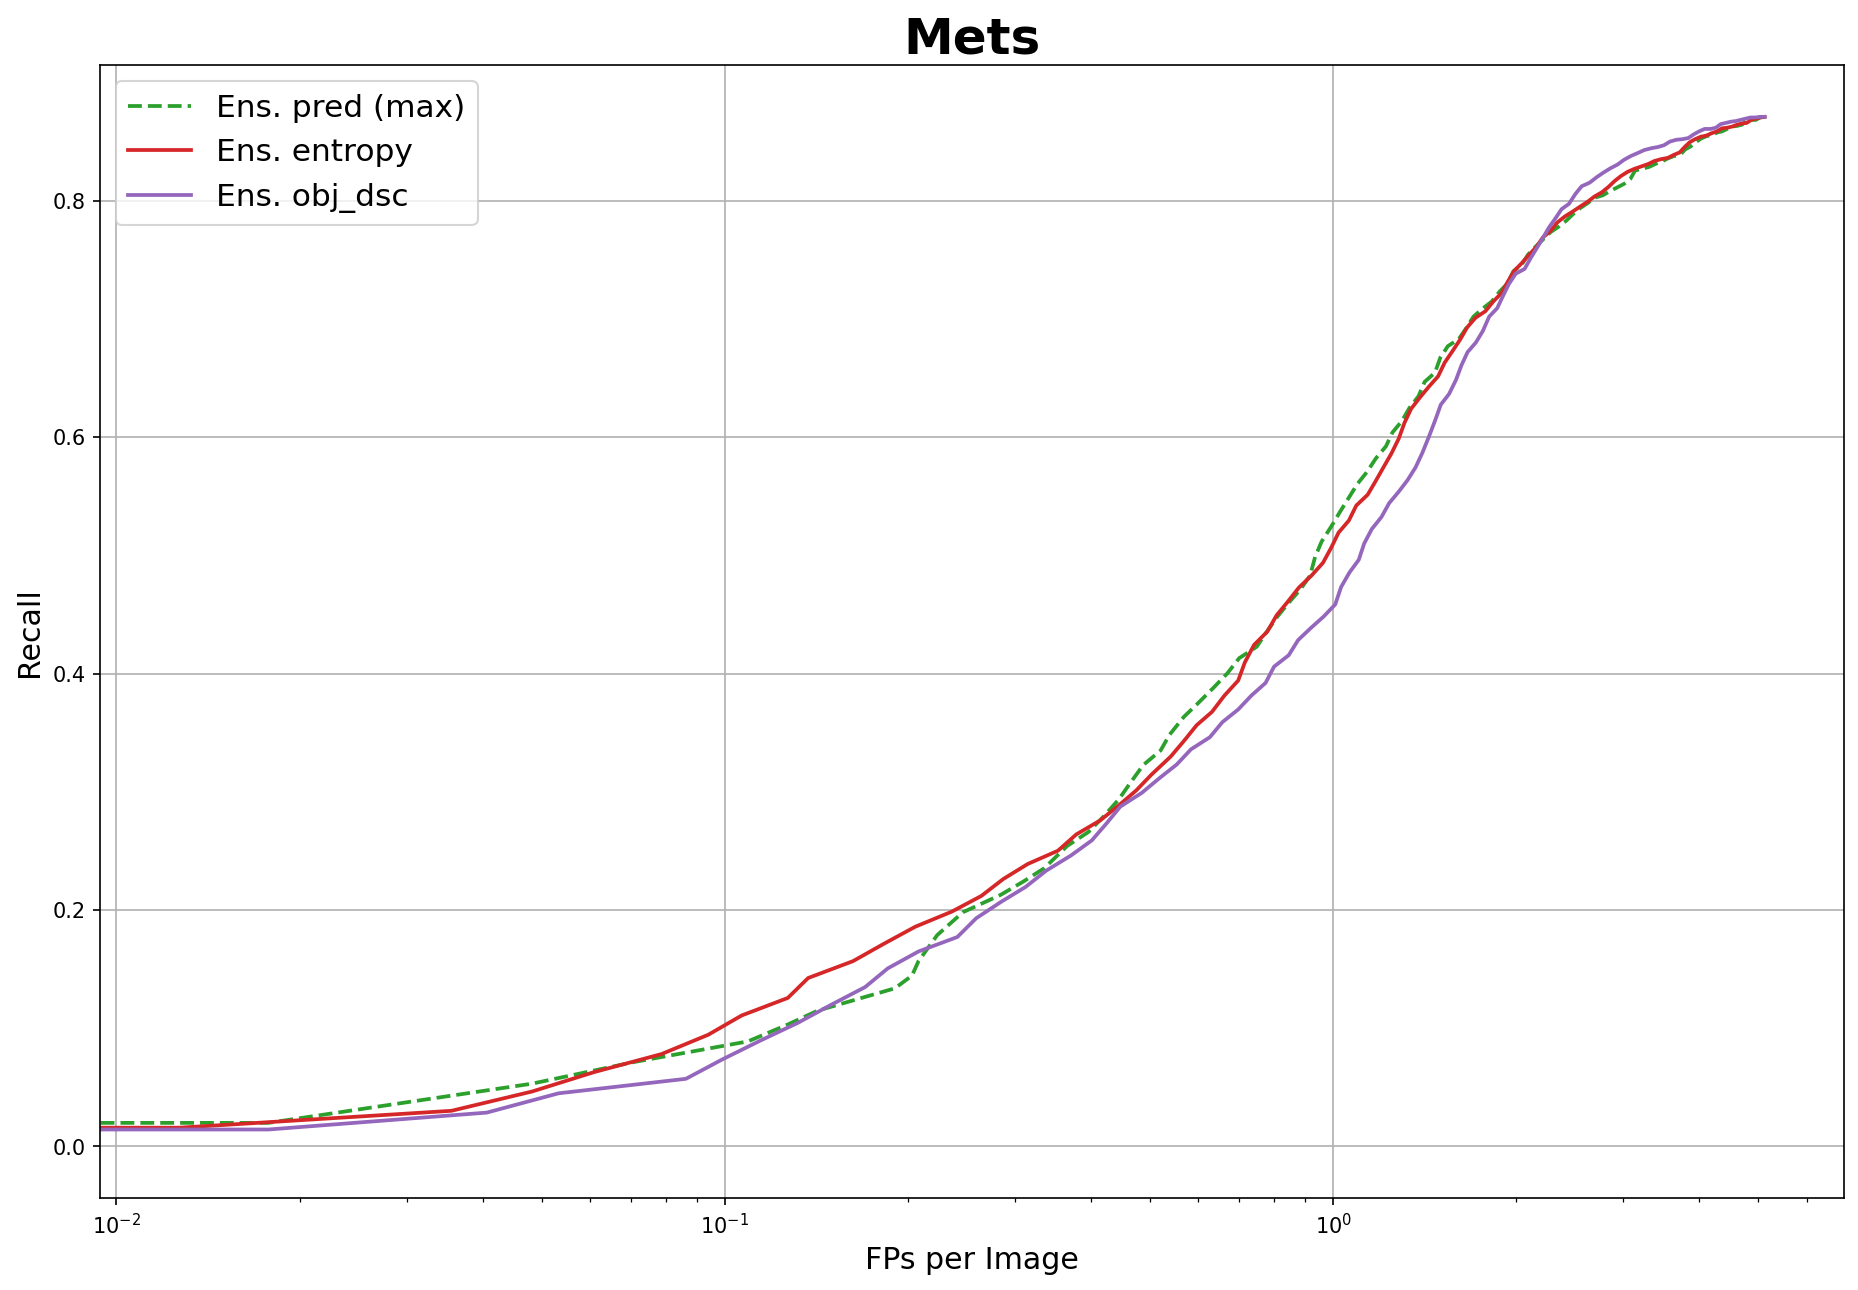

In [15]:
fig = plt.figure(figsize=(15, 10), dpi=150)
met_stats = plot_curves(['met'], setups, x="avg_fp", y="recall", num_points=100)

  0%|          | 0/104 [00:00<?, ?it/s]

pred_n|max           (avg recall) = 0.668, (fp@95recall) = 3.939


  0%|          | 0/104 [00:00<?, ?it/s]

entropy_n|mean       (avg recall) = 0.672, (fp@95recall) = 3.716


  0%|          | 0/104 [00:00<?, ?it/s]

obj_dsc|mean         (avg recall) = 0.673, (fp@95recall) = 3.173


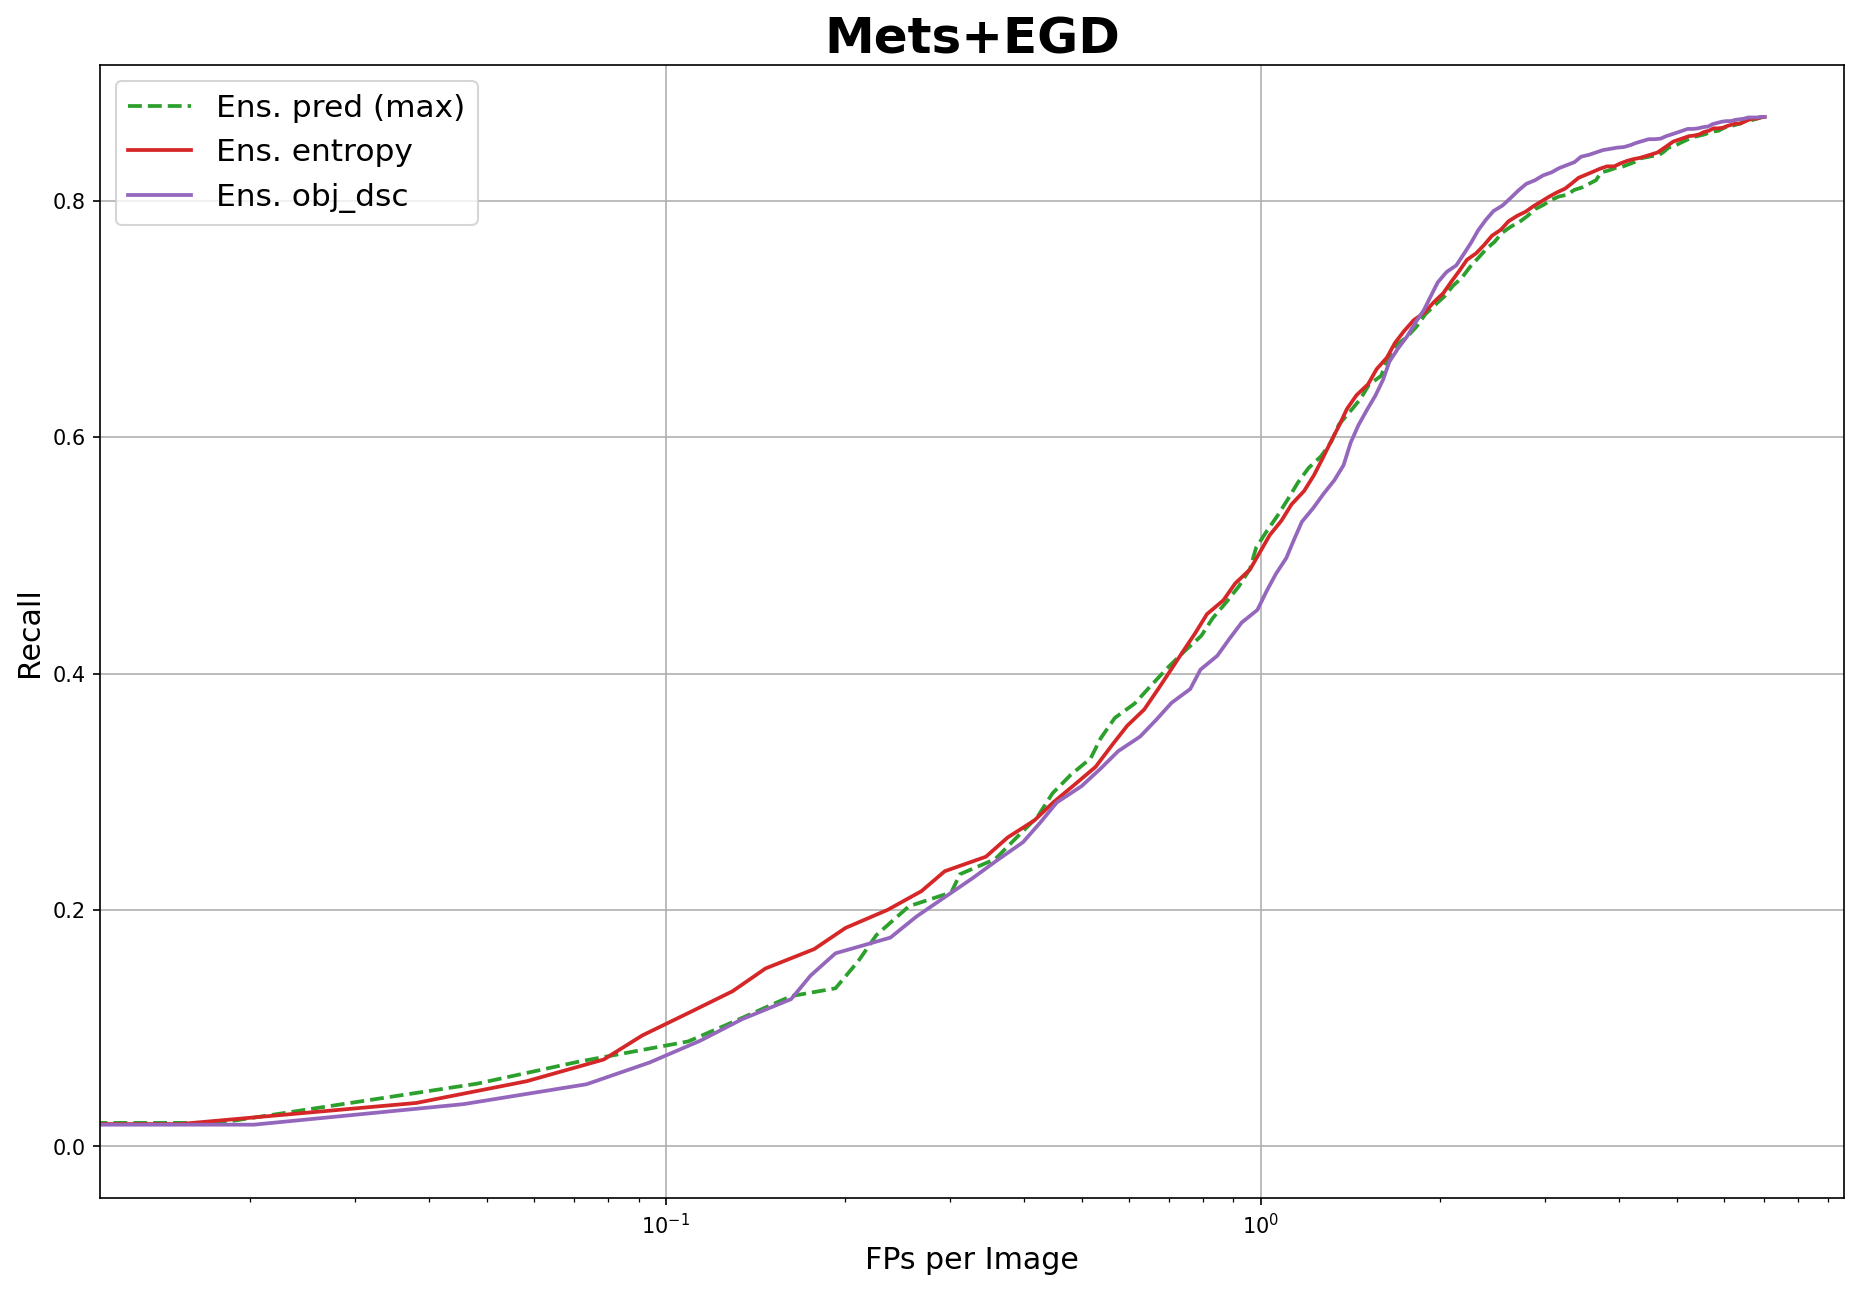

In [16]:
fig = plt.figure(figsize=(15, 10), dpi=150)
metedg_stats = plot_curves(['met', 'egd'], setups, x="avg_fp", y="recall", num_points=100)

  0%|          | 0/114 [00:00<?, ?it/s]

pred_n|max           (avg recall) = 0.708, (fp@95recall) = 1.565


  0%|          | 0/114 [00:00<?, ?it/s]

entropy_n|mean       (avg recall) = 0.706, (fp@95recall) = 1.531


  0%|          | 0/114 [00:00<?, ?it/s]

obj_dsc|mean         (avg recall) = 0.701, (fp@95recall) = 1.650


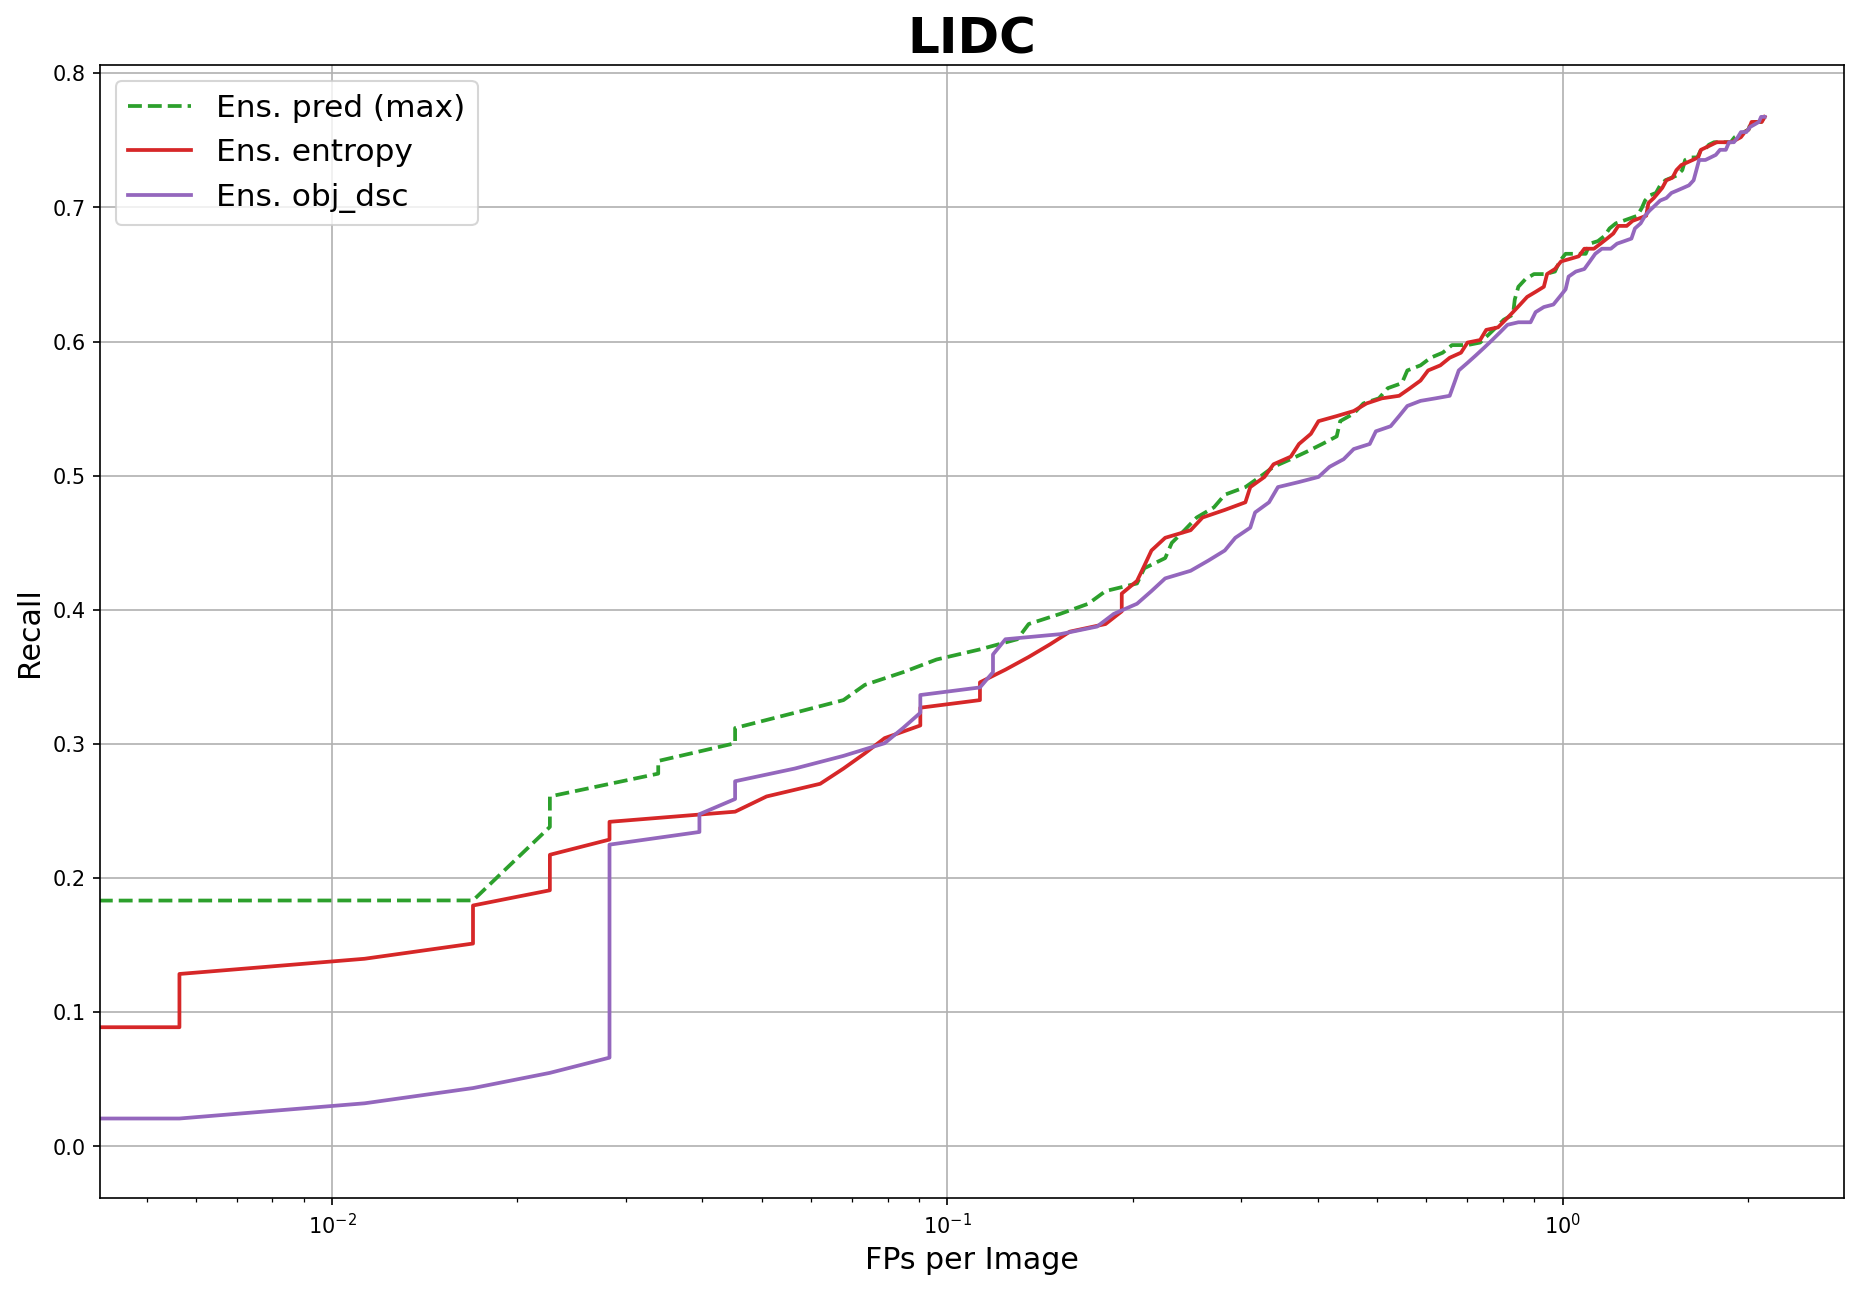

In [17]:
fig = plt.figure(figsize=(15, 10), dpi=150)
lidc_stats = plot_curves('lidc', setups, x="avg_fp", y="recall", num_points=100)

  0%|          | 0/108 [00:00<?, ?it/s]

pred_n|max           (avg recall) = 0.570, (fp@95recall) = 4.492


  0%|          | 0/108 [00:00<?, ?it/s]

entropy_n|mean       (avg recall) = 0.583, (fp@95recall) = 4.299


  0%|          | 0/108 [00:00<?, ?it/s]

obj_dsc|mean         (avg recall) = 0.598, (fp@95recall) = 4.243


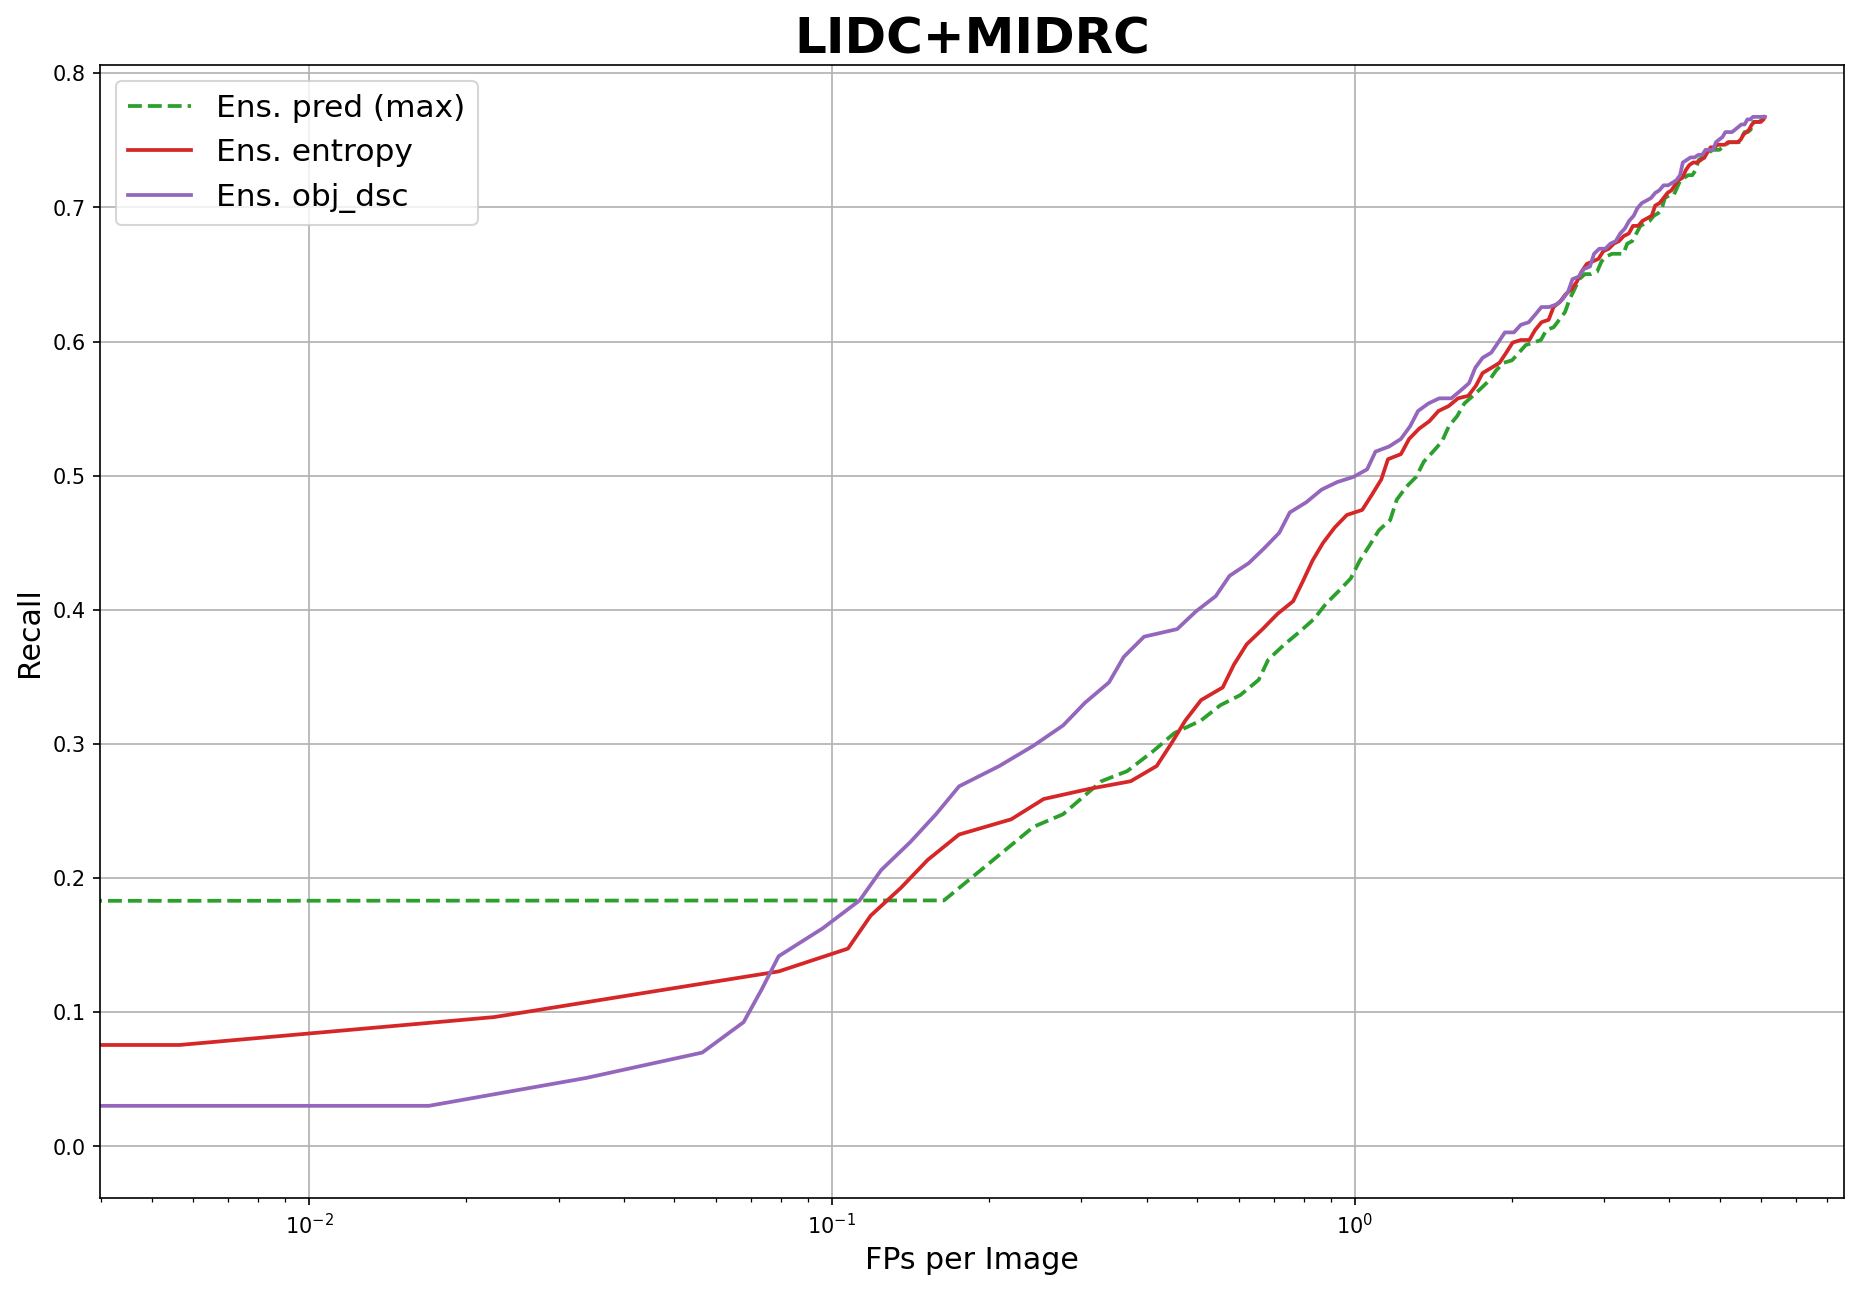

In [18]:
fig = plt.figure(figsize=(15, 10), dpi=150)
lidcmidrc_stats = plot_curves(['lidc', 'midrc'], setups, x="avg_fp", y="recall", num_points=100)

  0%|          | 0/122 [00:00<?, ?it/s]

pred_n|max           (avg recall) = 0.815, (fp@95recall) = 2.250


  0%|          | 0/122 [00:00<?, ?it/s]

entropy_n|mean       (avg recall) = 0.816, (fp@95recall) = 2.107


  0%|          | 0/122 [00:00<?, ?it/s]

obj_dsc|mean         (avg recall) = 0.809, (fp@95recall) = 2.321


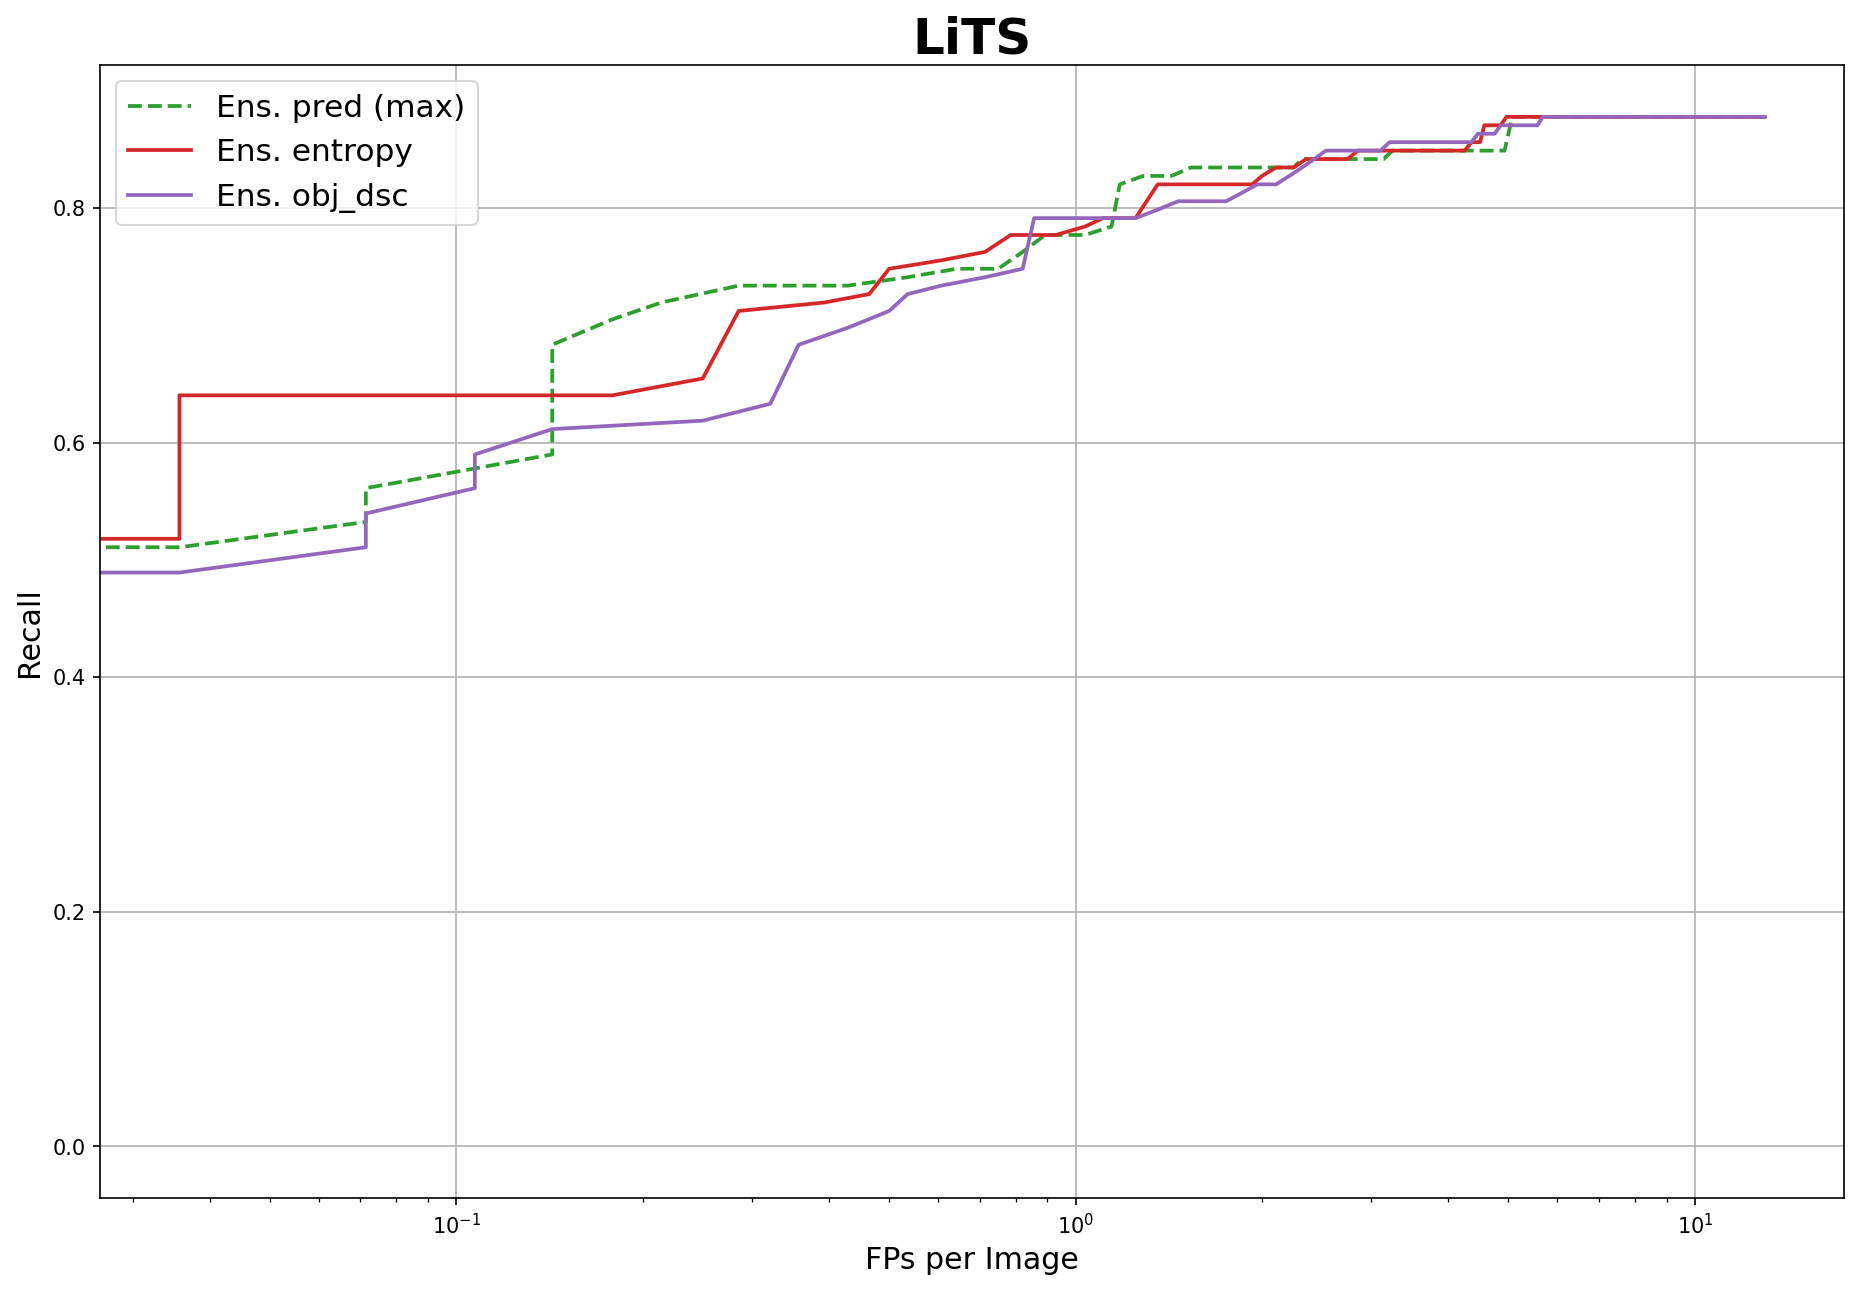

In [19]:
fig = plt.figure(figsize=(15, 10), dpi=150)
lits_stats = plot_curves(['lits'], setups, x="avg_fp", y="recall", num_points=100)

  0%|          | 0/105 [00:00<?, ?it/s]

pred_n|max           (avg recall) = 0.731, (fp@95recall) = 5.536


  0%|          | 0/105 [00:00<?, ?it/s]

entropy_n|mean       (avg recall) = 0.739, (fp@95recall) = 5.250


  0%|          | 0/105 [00:00<?, ?it/s]

obj_dsc|mean         (avg recall) = 0.760, (fp@95recall) = 4.857


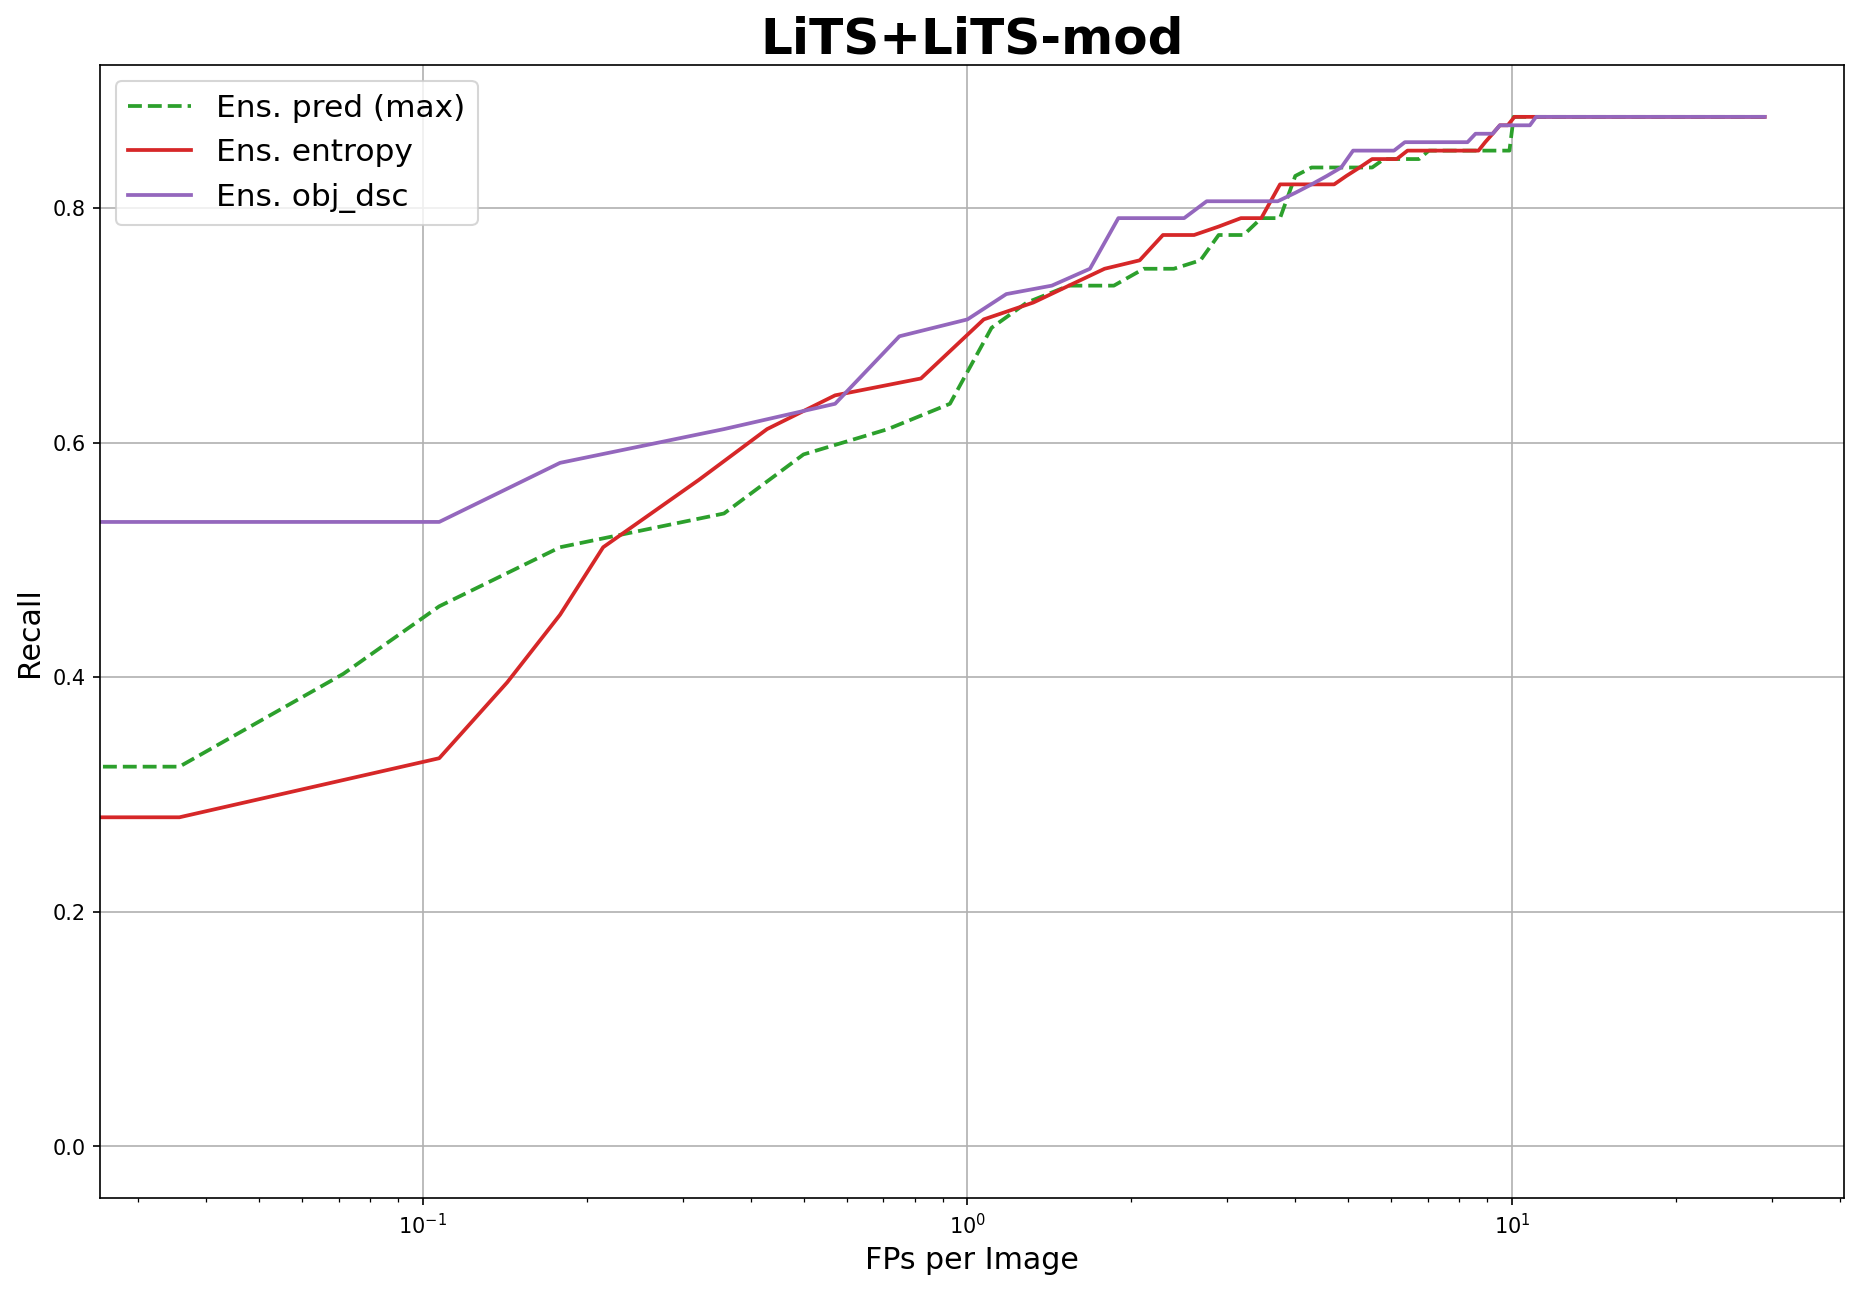

In [20]:
fig = plt.figure(figsize=(15, 10), dpi=150)
lits_lmod_stats = plot_curves(['lits', 'lits_mod'], setups, x="avg_fp", y="recall", num_points=100)

  0%|          | 0/122 [00:00<?, ?it/s]

pred_n|max           (avg recall) = 0.815, (fp@95recall) = 2.250


  0%|          | 0/122 [00:00<?, ?it/s]

entropy_n|mean       (avg recall) = 0.816, (fp@95recall) = 2.107


  0%|          | 0/122 [00:00<?, ?it/s]

obj_dsc|mean         (avg recall) = 0.809, (fp@95recall) = 2.321


  0%|          | 0/106 [00:00<?, ?it/s]

pred_1|max           (avg recall) = 0.682, (fp@95recall) = 2.627


  0%|          | 0/106 [00:00<?, ?it/s]

entropy_1|mean       (avg recall) = 0.681, (fp@95recall) = 2.780


  0%|          | 0/114 [00:00<?, ?it/s]

pred_n|max           (avg recall) = 0.708, (fp@95recall) = 1.565


  0%|          | 0/114 [00:00<?, ?it/s]

entropy_n|mean       (avg recall) = 0.706, (fp@95recall) = 1.531


  0%|          | 0/114 [00:00<?, ?it/s]

obj_dsc|mean         (avg recall) = 0.701, (fp@95recall) = 1.650


  0%|          | 0/102 [00:00<?, ?it/s]

pred_1|max           (avg recall) = 0.656, (fp@95recall) = 4.563


  0%|          | 0/102 [00:00<?, ?it/s]

entropy_1|mean       (avg recall) = 0.660, (fp@95recall) = 4.282


  0%|          | 0/102 [00:00<?, ?it/s]

pred_n|max           (avg recall) = 0.687, (fp@95recall) = 3.221


  0%|          | 0/102 [00:00<?, ?it/s]

entropy_n|mean       (avg recall) = 0.687, (fp@95recall) = 3.129


  0%|          | 0/102 [00:00<?, ?it/s]

obj_dsc|mean         (avg recall) = 0.680, (fp@95recall) = 2.858


  0%|          | 0/105 [00:00<?, ?it/s]

pred_n|max           (avg recall) = 0.731, (fp@95recall) = 5.536


  0%|          | 0/105 [00:00<?, ?it/s]

entropy_n|mean       (avg recall) = 0.739, (fp@95recall) = 5.250


  0%|          | 0/105 [00:00<?, ?it/s]

obj_dsc|mean         (avg recall) = 0.760, (fp@95recall) = 4.857


  0%|          | 0/102 [00:00<?, ?it/s]

pred_1|max           (avg recall) = 0.518, (fp@95recall) = 7.130


  0%|          | 0/102 [00:00<?, ?it/s]

entropy_1|mean       (avg recall) = 0.538, (fp@95recall) = 7.237


  0%|          | 0/108 [00:00<?, ?it/s]

pred_n|max           (avg recall) = 0.570, (fp@95recall) = 4.492


  0%|          | 0/108 [00:00<?, ?it/s]

entropy_n|mean       (avg recall) = 0.583, (fp@95recall) = 4.299


  0%|          | 0/108 [00:00<?, ?it/s]

obj_dsc|mean         (avg recall) = 0.598, (fp@95recall) = 4.243


  0%|          | 0/102 [00:00<?, ?it/s]

pred_1|max           (avg recall) = 0.627, (fp@95recall) = 6.381


  0%|          | 0/102 [00:00<?, ?it/s]

entropy_1|mean       (avg recall) = 0.641, (fp@95recall) = 5.744


  0%|          | 0/104 [00:00<?, ?it/s]

pred_n|max           (avg recall) = 0.668, (fp@95recall) = 3.939


  0%|          | 0/104 [00:00<?, ?it/s]

entropy_n|mean       (avg recall) = 0.672, (fp@95recall) = 3.716


  0%|          | 0/104 [00:00<?, ?it/s]

obj_dsc|mean         (avg recall) = 0.673, (fp@95recall) = 3.173


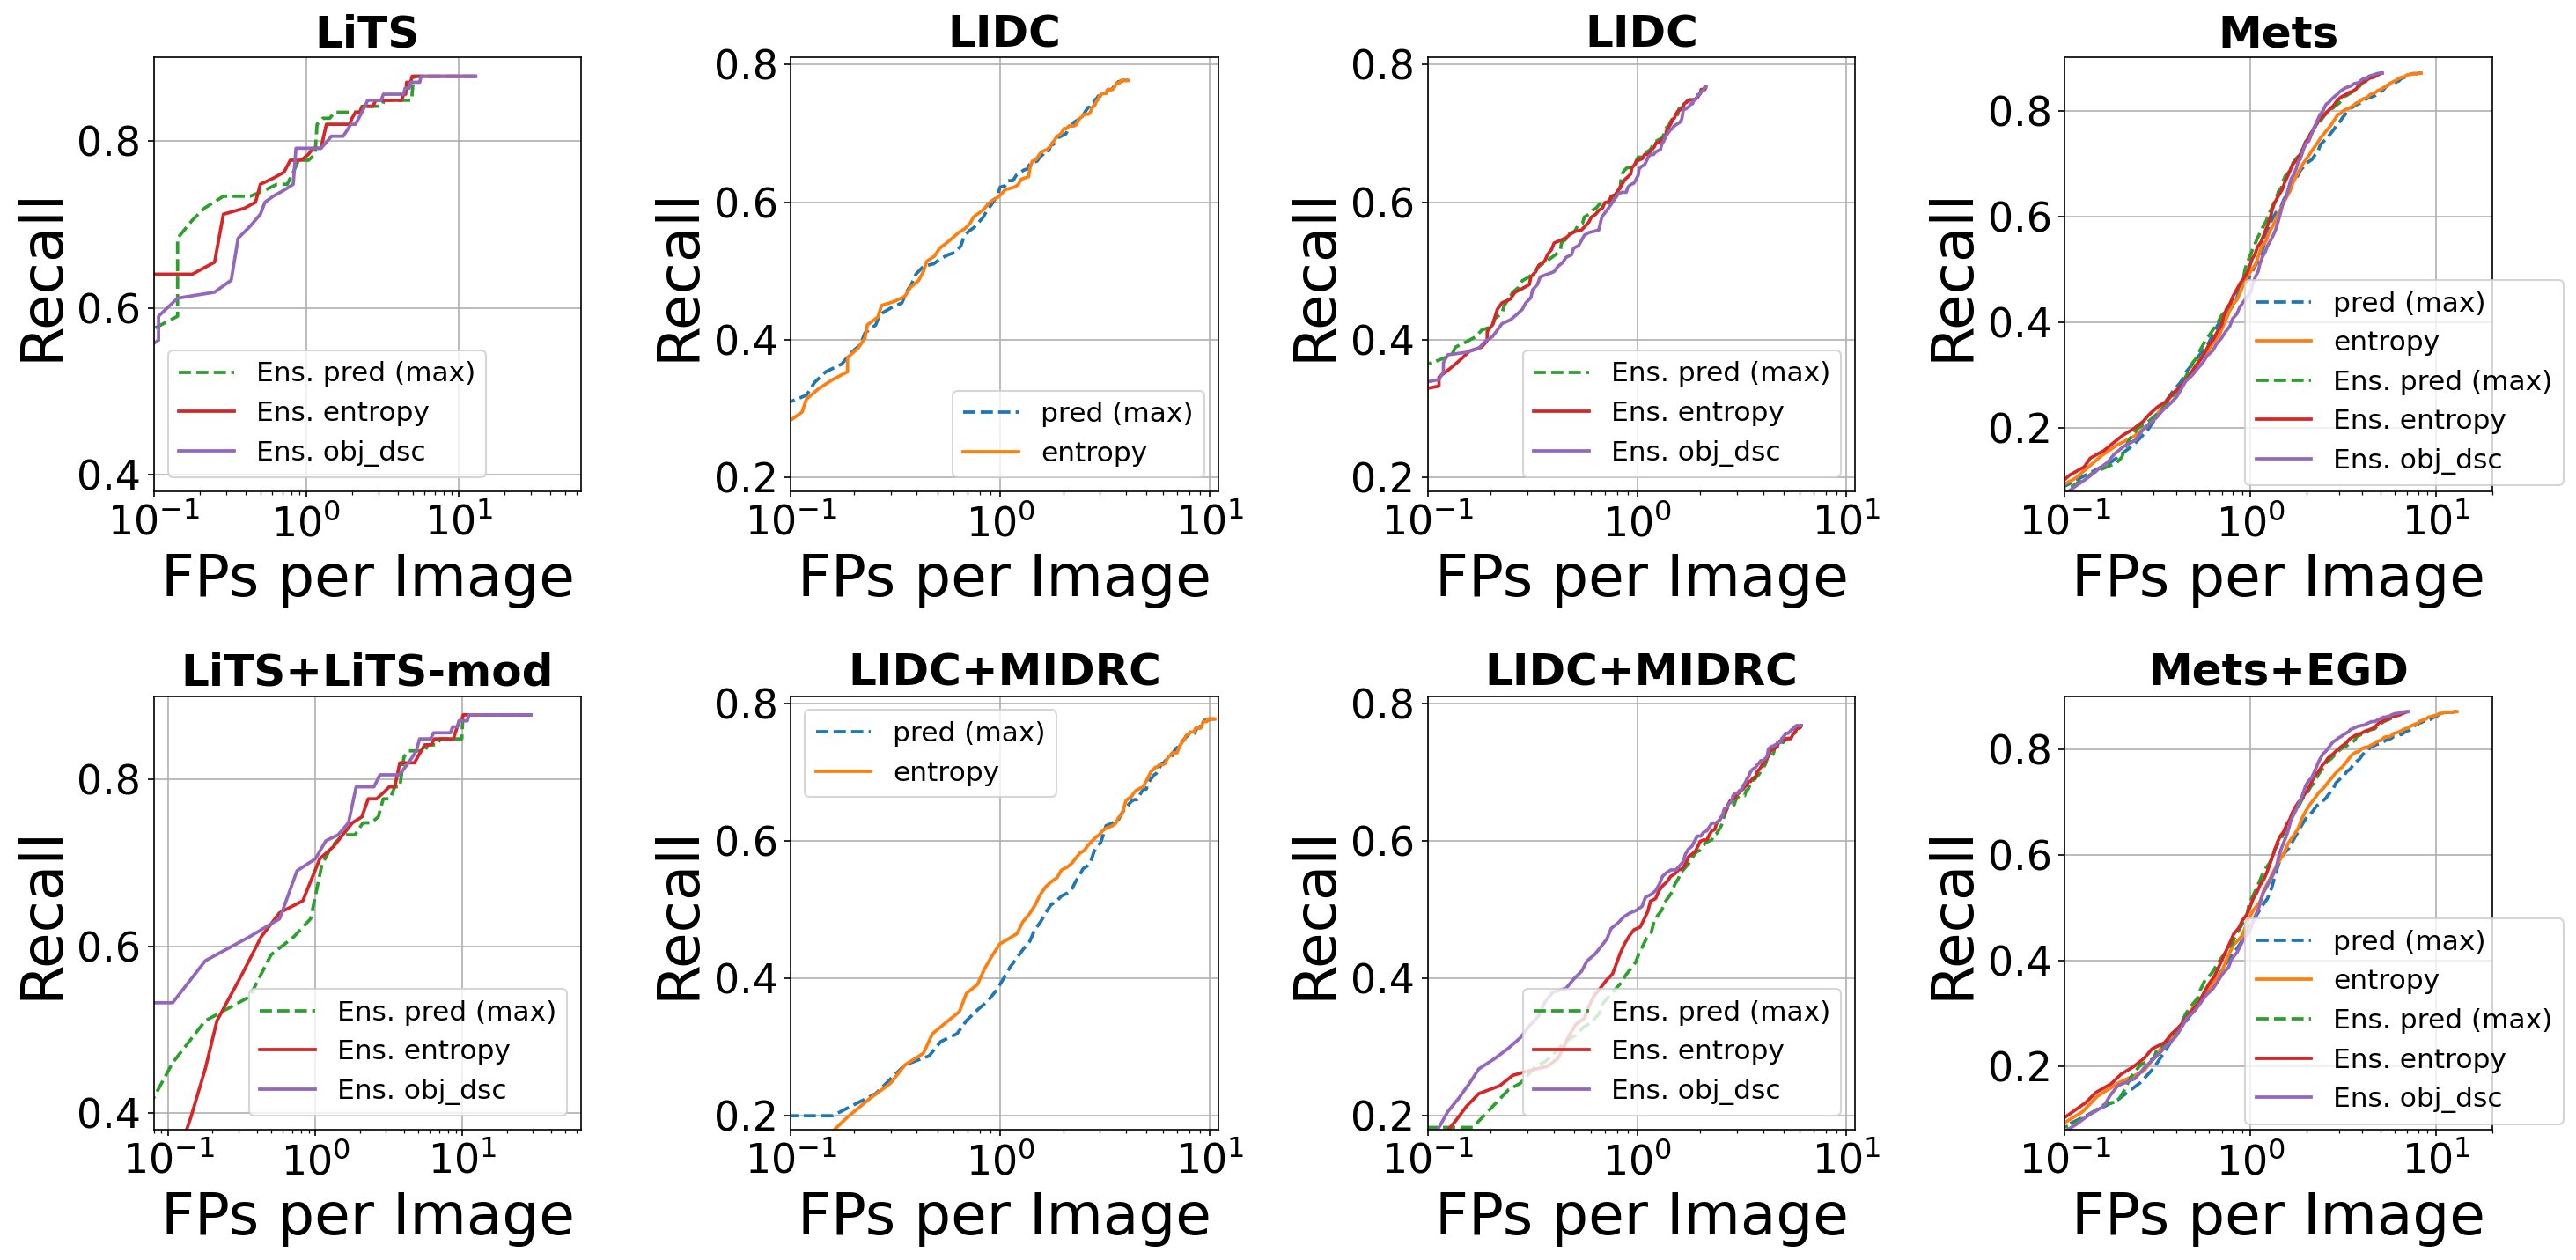

In [606]:
setups_g = [('pred_n', 'max', ge, 0.5),
         ('entropy_n', 'mean', le, 0.5),
         ('obj_dsc', 'mean', ge, 0.5)]

setups_single_g = [('pred_1', 'max', ge, 0.5),
         ('entropy_1', 'mean', le, 0.5)]
# plt.rcParams.update({'font.size': 20})

fig = plt.figure(figsize=(20, 10), dpi=150)


ax = fig.add_subplot(2,4,1)
# plot_curves(['lits'], setups_single_g, x="avg_fp", y="recall", num_points=100, from_single=True)
plot_curves(['lits'], setups_g, x="avg_fp", y="recall", num_points=100)
plt.xlim(0.1, 64)
plt.ylim(0.38, 0.9)

ax = fig.add_subplot(2,4,2)

plot_curves(['lidc'], setups_single_g, x="avg_fp", y="recall", num_points=100, from_single=True, have_labels=True)
# plot_curves(['lidc'], setups_g, x="avg_fp", y="recall", num_points=100, have_labels=True)
plt.xlim(0.1, 11)
plt.ylim(0.18, 0.81)

ax = fig.add_subplot(2,4,3)
plot_curves(['lidc'], setups_g, x="avg_fp", y="recall", num_points=100, have_labels=True)

plt.xlim(0.1, 11)
plt.ylim(0.18, 0.81)

ax = fig.add_subplot(2,4, 4)

plot_curves(['met'], setups_single_g, x="avg_fp", y="recall", num_points=100, from_single=True, have_labels=True)
plot_curves(['met'], setups_g, x="avg_fp", y="recall", num_points=100, have_labels=True)
plt.xlim(0.1, 20)
plt.ylim(0.08, 0.9)
plt.legend(loc="center right", bbox_to_anchor=(1.2, 0.25), fontsize=15)

ax = fig.add_subplot(2,4, 5)

# plot_curves(['lits', 'lits_mod'], setups_single_g, x="avg_fp", y="recall", num_points=100, from_single=True)
plot_curves(['lits', 'lits_mod'], setups_g, x="avg_fp", y="recall", num_points=100)
plt.xlim(0.08, 64)
plt.ylim(0.38, 0.9)

ax = fig.add_subplot(2,4,6)

plot_curves(['lidc', "midrc"], setups_single_g, x="avg_fp", y="recall", num_points=100, from_single=True)
# plot_curves(['lidc', "midrc"], setups_g, x="avg_fp", y="recall", num_points=100)
plt.xlim(0.1, 11)
plt.ylim(0.18, 0.81)

ax = fig.add_subplot(2,4,7)
plot_curves(['lidc', "midrc"], setups_g, x="avg_fp", y="recall", num_points=100)

plt.xlim(0.1, 11)
plt.ylim(0.18, 0.81)

ax = fig.add_subplot(2,4, 8)

plot_curves(['met', 'egd'], setups_single_g, x="avg_fp", y="recall", num_points=100, from_single=True, have_labels=True)
plot_curves(['met', 'egd'], setups_g, x="avg_fp", y="recall", num_points=100, have_labels=True)
plt.xlim(0.1, 20)
plt.ylim(0.08, 0.9)
plt.legend(loc="center right", bbox_to_anchor=(1.2, 0.25), fontsize=15)

plt.tight_layout()
plt.savefig("../imgs/frocs2.png", bbox_inches="tight")

In [664]:
all_stats_combined = [lits_stats, lits_lmod_stats, lidc_stats, lidcmidrc_stats, met_stats, metedg_stats]
all_stats_sep = []
index = ["lits", "lits+litsmod", "lidc", "lidc+midrc", "met", "met_edg"]
index_sep= []
# for key in ['avg_recall', 'fp@95recall', 'fpr@95reduction']:
# for key in ['fpr@95reduction']:
for key in ['fpr@95reduction', 'avg_recall']:

    all_stats_sep.extend([{k: v[key] for k, v in x.items()} for x in all_stats_combined])
    index_sep.extend([x + key for x in index])
froc_stats = pd.DataFrame(all_stats_sep, index=index_sep)
froc_stats = froc_stats.T
froc_stats

,litsfpr@95reduction,lits+litsmodfpr@95reduction,lidcfpr@95reduction,lidc+midrcfpr@95reduction,metfpr@95reduction,met_edgfpr@95reduction,litsavg_recall,lits+litsmodavg_recall,lidcavg_recall,lidc+midrcavg_recall,metavg_recall,met_edgavg_recall
logit_n|mean,0.829201,0.820859,0.270557,0.288765,0.388696,0.470758,0.814956,0.738586,0.707478,0.584311,0.688713,0.673903
logit_n|median,0.796143,0.798773,0.233422,0.225627,0.388696,0.470758,0.814550,0.736807,0.705646,0.583992,0.685295,0.670464
logit_n|min,0.002755,0.007362,0.021220,0.057567,0.033713,0.035379,0.070865,0.027940,0.578873,0.359662,0.382786,0.293746
logit_n|q5,0.796143,0.808589,0.153846,0.212628,0.332672,0.406498,0.799181,0.720975,0.681945,0.558074,0.658304,0.638404
logit_n|max,0.826446,0.809816,0.265252,0.261838,0.370848,0.439711,0.814718,0.731393,0.707928,0.570582,0.687198,0.668490
logit_n|q95,0.840220,0.820859,0.267905,0.273909,0.372831,0.455596,0.814405,0.737461,0.707879,0.577690,0.687111,0.670160
logit_n|sum_log,0.272727,0.280982,0.169761,0.299907,0.370848,0.470758,0.752974,0.642969,0.698083,0.524061,0.675460,0.649506
pred_n|mean,0.818182,0.809816,0.267905,0.287837,0.388696,0.470397,0.817062,0.740576,0.705331,0.582302,0.685827,0.670984
pred_n|median,0.796143,0.798773,0.233422,0.225627,0.388696,0.470758,0.814550,0.736807,0.705585,0.583933,0.685277,0.670454
pred_n|min,0.002755,0.007362,0.021220,0.057567,0.033713,0.035379,0.070865,0.027940,0.578873,0.359662,0.382796,0.293746


In [640]:
selected_methods = [
  'pred_n|max',
  'avg_entropy|min',
  'logit_n|mean',
  'pred_n|mean',
  'entropy_n|mean',
  'mutual_info|mean',
  'obj_dsc|mean',
  'dispersion|min',
    ] 

froc_stats.loc[selected_methods]#.sort_values(by="litsfpr@95reduction", ascending=False)
froc_stats.loc[selected_methods]

In [669]:
import re
# tex_string = froc_stats.loc[selected_methods].to_latex(float_format="%.2f")
tex_string = froc_stats.to_latex(float_format="%.2f")
print(re.sub(' {2,}',' ', tex_string))


\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{} & litsfpr@95reduction & lits+litsmodfpr@95reduction & lidcfpr@95reduction & lidc+midrcfpr@95reduction & metfpr@95reduction & met\_edgfpr@95reduction & litsavg\_recall & lits+litsmodavg\_recall & lidcavg\_recall & lidc+midrcavg\_recall & metavg\_recall & met\_edgavg\_recall \\
\midrule
logit\_n|mean & 0.83 & 0.82 & 0.27 & 0.29 & 0.39 & 0.47 & 0.81 & 0.74 & 0.71 & 0.58 & 0.69 & 0.67 \\
logit\_n|median & 0.80 & 0.80 & 0.23 & 0.23 & 0.39 & 0.47 & 0.81 & 0.74 & 0.71 & 0.58 & 0.69 & 0.67 \\
logit\_n|min & 0.00 & 0.01 & 0.02 & 0.06 & 0.03 & 0.04 & 0.07 & 0.03 & 0.58 & 0.36 & 0.38 & 0.29 \\
logit\_n|q5 & 0.80 & 0.81 & 0.15 & 0.21 & 0.33 & 0.41 & 0.80 & 0.72 & 0.68 & 0.56 & 0.66 & 0.64 \\
logit\_n|max & 0.83 & 0.81 & 0.27 & 0.26 & 0.37 & 0.44 & 0.81 & 0.73 & 0.71 & 0.57 & 0.69 & 0.67 \\
logit\_n|q95 & 0.84 & 0.82 & 0.27 & 0.27 & 0.37 & 0.46 & 0.81 & 0.74 & 0.71 & 0.58 & 0.69 & 0.67 \\
logit\_n|sum\_log & 0.27 & 0.28 & 0.17 & 0.30 & 0.37 & 0.47 & 0.75 &

/tmp/ipykernel_1383223/656953057.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_string = froc_stats.to_latex(float_format="%.2f")
